In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# _Install fastai & dependencies:_
_NB: Because fastai.callbacks is deprecated in fastai v2, will need to try and install v1:_

In [ ]:
# check python version:
import sys
sys.version

'3.7.14 (default, Sep  8 2022, 00:06:44) \n[GCC 7.5.0]'

In [ ]:
# install fastai version 1:
!python -m pip install 'fastai>=1.00,<2.00'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 239 kB 5.2 MB/s 
     |████████████████████████████████| 355 kB 45.2 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=b2393dee51feec99615e722449628d558a4e6b1e306e6cb9a21517df652b4dbd
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9


In [ ]:
# install openslide:
!apt-get install openslide-tools python3-openslide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  javascript-common libjs-jquery libopenslide0 python-asn1crypto
  python-blinker python-cffi-backend python-click python-colorama
  python-cryptography python-enum34 python-flask python-idna python-ipaddress
  python-itsdangerous python-jinja2 python-markupsafe
  python-openslide-examples python-openssl python-pkg-resources
  python-pyinotify python-simplejson python-six python-werkzeug
  python3-olefile python3-pil
Suggested packages:
  apache2 | lighttpd | httpd libtiff-tools python-blinker-doc
  python-cryptography-doc python-cryptography-vectors python-enum34-doc
  python-flask-doc python-jinja2-doc python-openssl-doc python-openssl-dbg
  python-setuptools python-pyinotify-doc ipython python-genshi pyt

In [ ]:
# install sliderunner:
!python -m pip install -U SlideRunner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511 kB 4.8 MB/s 
     |████████████████████████████████| 98 kB 6.1 MB/s 
     |████████████████████████████████| 2.0 MB 51.1 MB/s 
     |████████████████████████████████| 8.4 MB 25.5 MB/s 
     |████████████████████████████████| 59.9 MB 1.3 MB/s 
     |████████████████████████████████| 344 kB 71.6 MB/s 


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet
from lib.sampling import get_slides
size=512
path = Path('./')

database = Database()
database.open('databases/MITOS_WSI_CMC_MEL.sqlite')

slidelist_test_1 = ['14','18','3','22','10','15','21']
slidelist_test_2 = ['1','20','17','5','2','11','16']
slidelist_test_3 = ['13','7','19','8','6','9', '12']
slidelist_test = slidelist_test_1

## Split dataset into train/validation and test on slide level

Convert database into in-memory object

In [ ]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, negative_class=1,  size=size,database=database,basepath='./WSI')

Loading slides .. : 100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


In [ ]:
print(f'lbl_bbox is of data type: {type(lbl_bbox)} with length {len(lbl_bbox)}')

lbl_bbox is of data type: <class 'list'> with length 28


In [ ]:
img2bbox = dict(zip(files, np.array(lbl_bbox, dtype=object)))
get_y_func = lambda o:img2bbox[o]

In [ ]:
bs = 12
train_images = 5000
val_images = 5000

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))

#train_files = list(np.random.choice(files, train_images))
#valid_files = list(np.random.choice(files, val_images))


In [ ]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )


In [ ]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


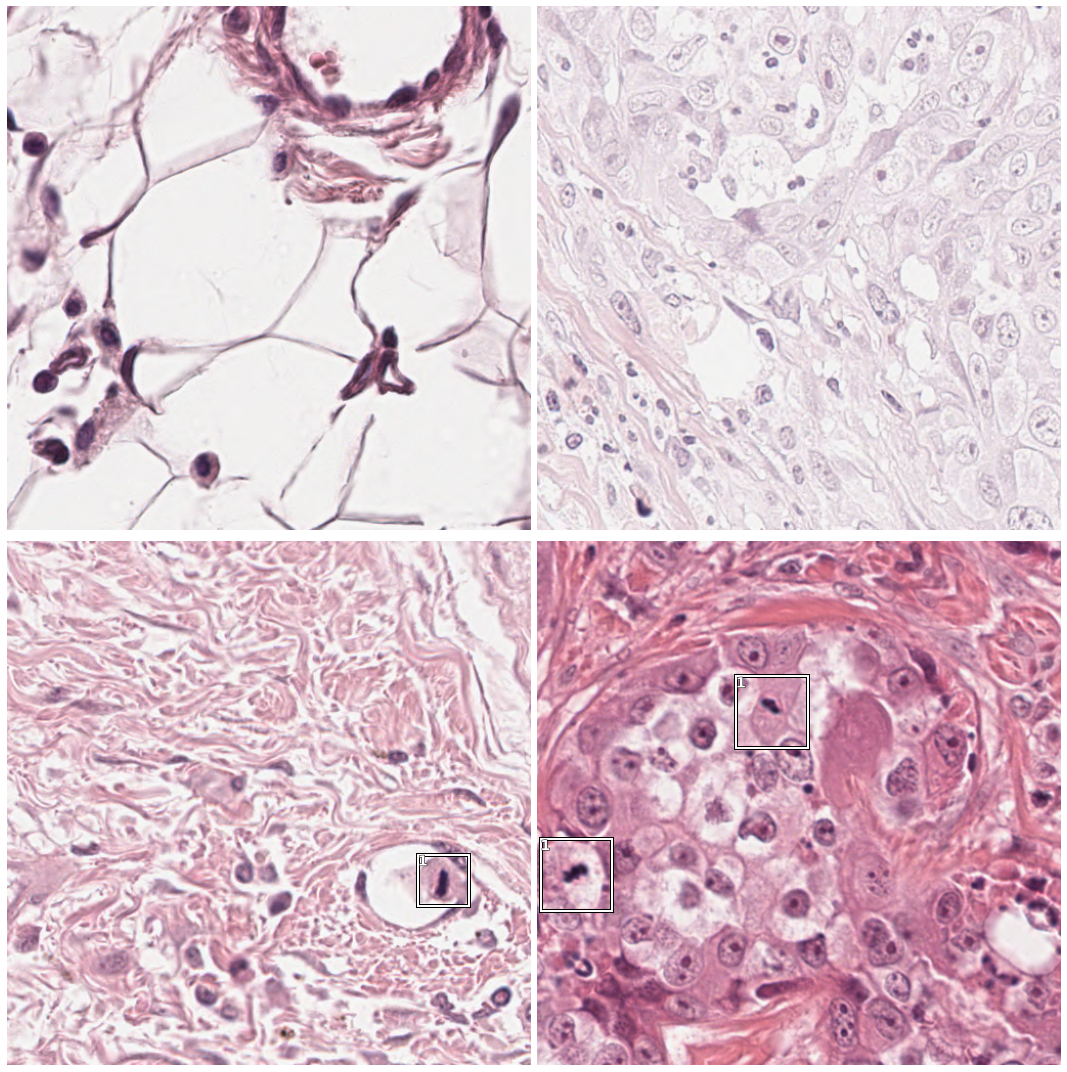

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Train, figsize=(15,15))

In [ ]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7,0.8])


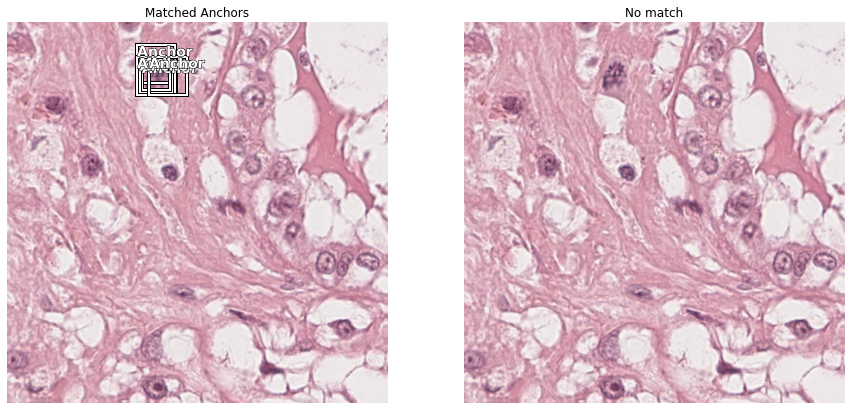

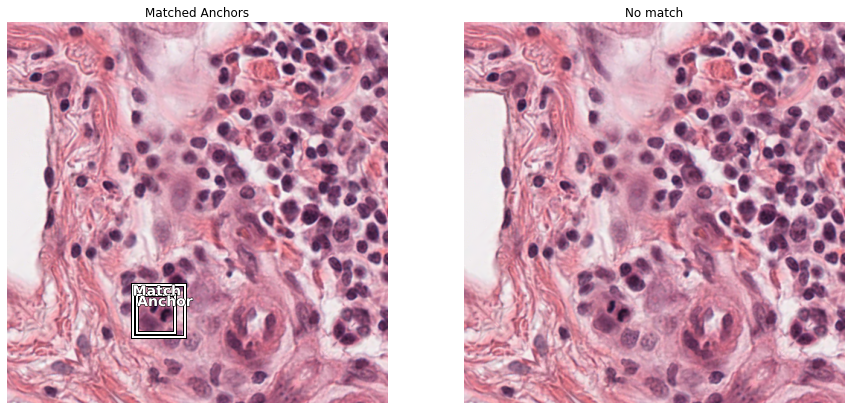

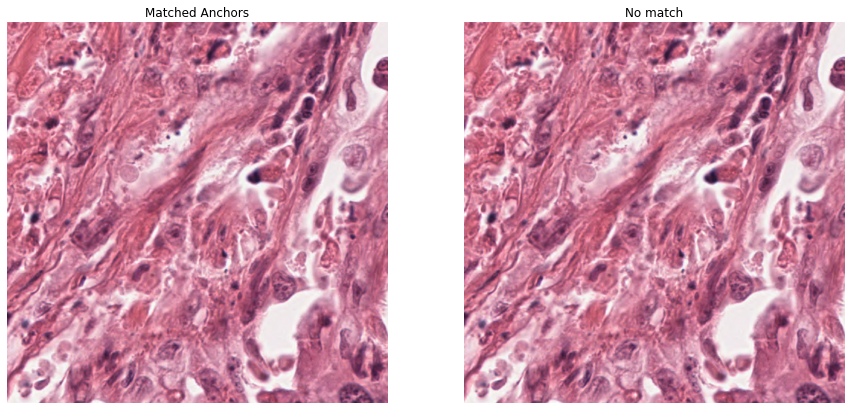

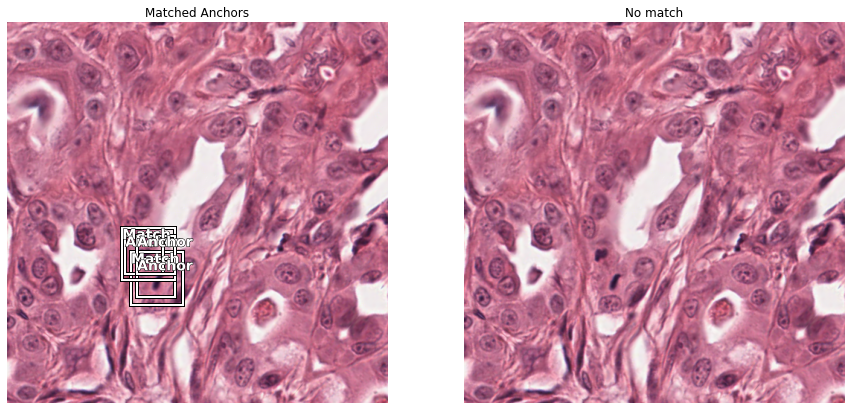

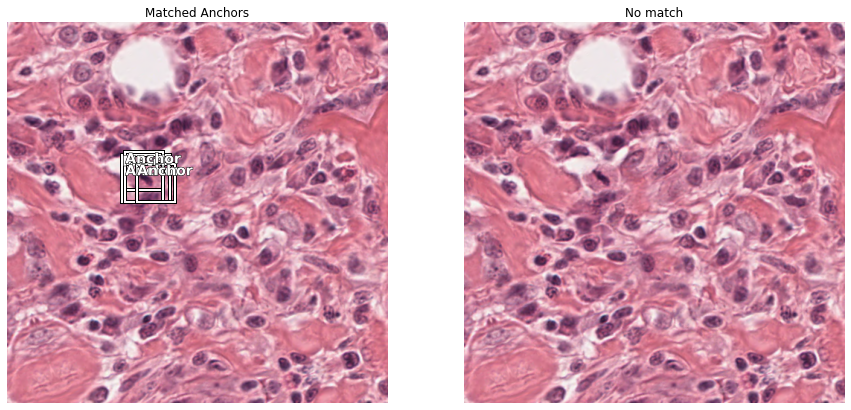

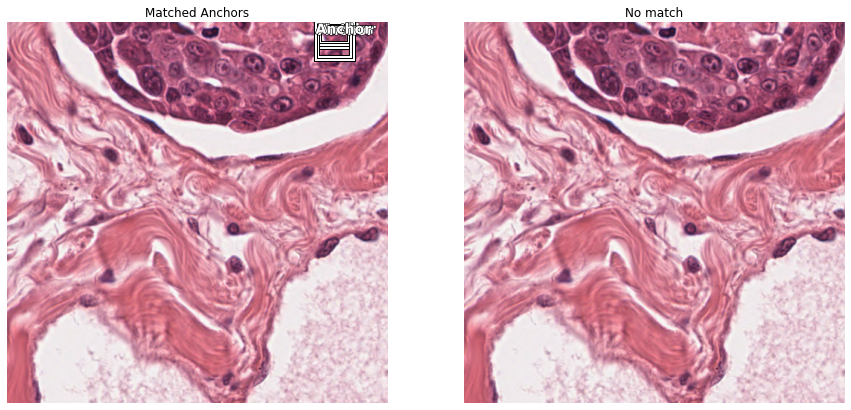

In [ ]:
not_found = show_anchors_on_images(data, anchors)

In [ ]:
crit = RetinaNetFocalLoss(anchors)

In [ ]:
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[32], chs=128, final_bias=-4., n_conv=3)



/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [ ]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


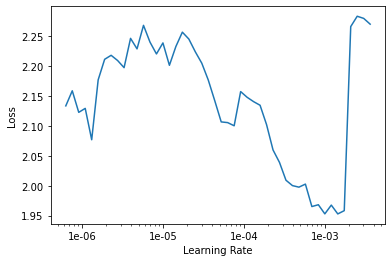

In [ ]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 2770/2770 [00:01<00:00, 2371.85it/s]


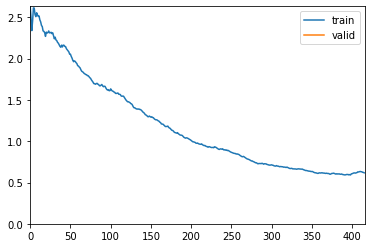

In [ ]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 2488/2488 [00:00<00:00, 2699.84it/s]


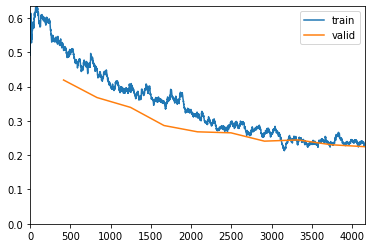

GT: 100%|██████████| 2643/2643 [00:00<00:00, 2675.46it/s]


In [ ]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 2661/2661 [00:00<00:00, 2713.38it/s]


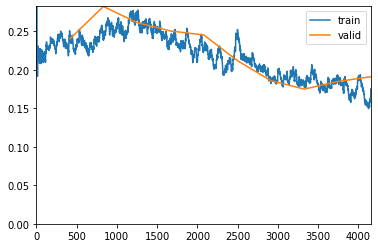

GT: 100%|██████████| 2767/2767 [00:01<00:00, 2712.25it/s]


In [ ]:
learn.unfreeze()
lr=1e-4

learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 2682/2682 [00:00<00:00, 2865.54it/s]


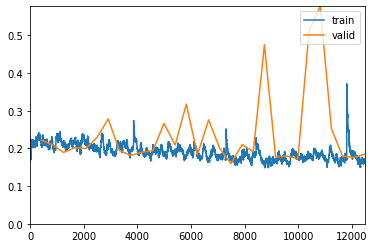

Better model found at epoch 0 with valid_loss value: 0.22216148674488068.


GT: 100%|██████████| 2853/2853 [00:01<00:00, 2582.76it/s]


Better model found at epoch 1 with valid_loss value: 0.2098817080259323.


GT: 100%|██████████| 2853/2853 [00:01<00:00, 2487.21it/s]


Better model found at epoch 2 with valid_loss value: 0.18943512439727783.


GT: 100%|██████████| 2829/2829 [00:01<00:00, 2600.21it/s]


Better model found at epoch 8 with valid_loss value: 0.1814383715391159.


GT: 100%|██████████| 2845/2845 [00:01<00:00, 2673.71it/s]


Better model found at epoch 17 with valid_loss value: 0.15982720255851746.


GT: 100%|██████████| 2687/2687 [00:00<00:00, 2895.39it/s]


In [ ]:
learn.unfreeze()
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', name='model')])

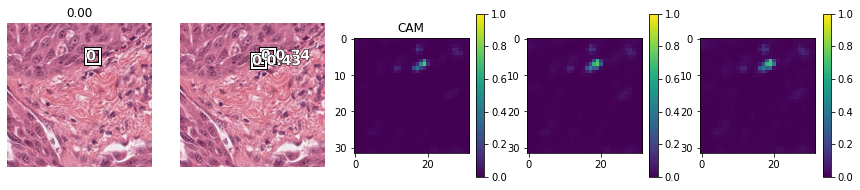

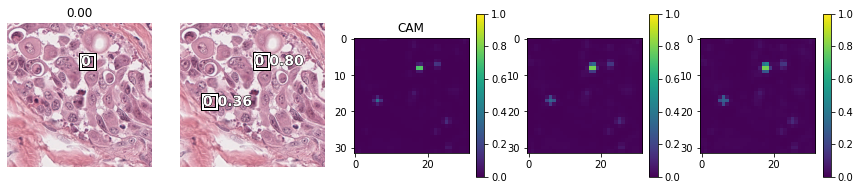

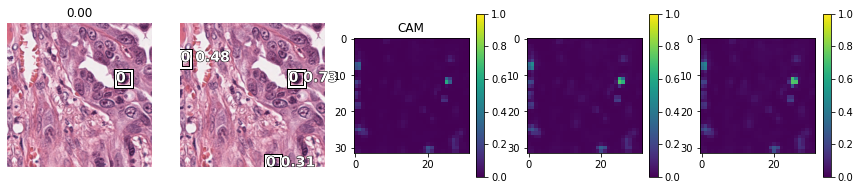

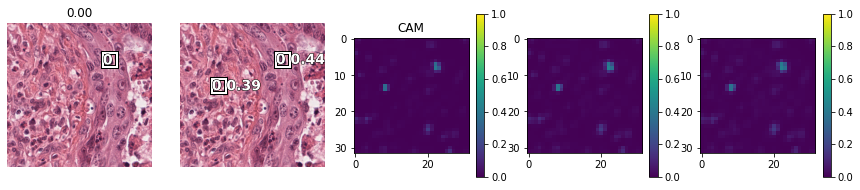

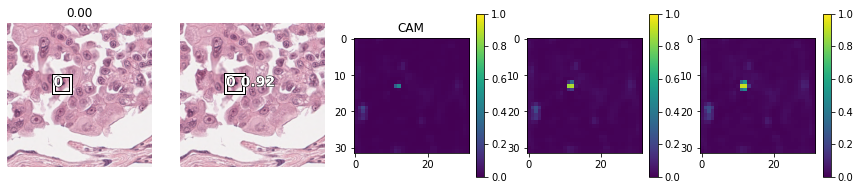

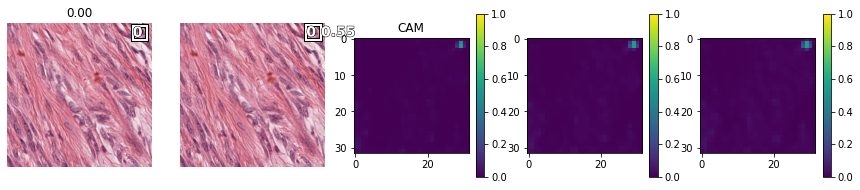

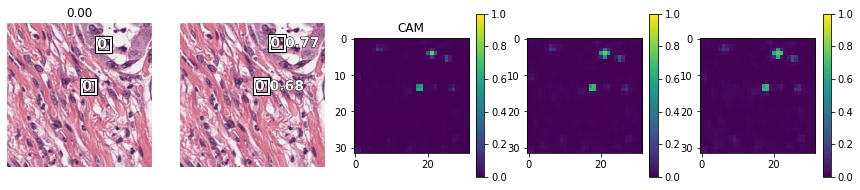

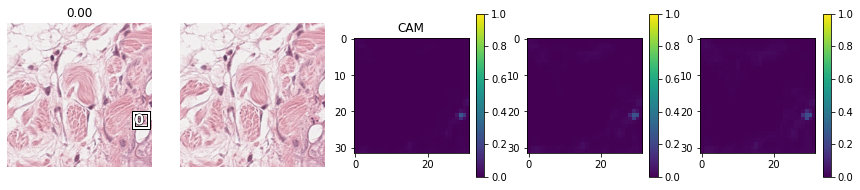

In [ ]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [ ]:
learn.save('RetinaNet-CMC-MEL-512sh-batch1', with_opt=True)
learn.export("RetinaNet-CMC-MEL-512sh-b1.pth")

In [ ]:
torch.save(learn.model.state_dict(), "RetinaNet-CMC-MEL-512sh-batch1_statedict.pth")

In [ ]:
learn.data.stats

[tensor([0.7480, 0.5764, 0.6672]), tensor([0.1958, 0.2398, 0.1931])]